# Importacion de librerias

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import issparse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler


# Definición de funciones de carga y preprocesamiento de datos

In [23]:
def cargar_datos():
    riesgo = pd.read_excel('Cartera de créditos por clasificación de riesgo.xlsx')
    genero = pd.read_excel('Cartera de créditos por genero.xlsx')
    localidad = pd.read_excel('Cartera de créditos por localidad.xlsx')
    sectores = pd.read_excel('Cartera de créditos por sectores económicos.xlsx')
    return riesgo, genero, localidad, sectores

def validar_datos(df):
    df = df.drop_duplicates()
    if df.isnull().sum().sum() > 0:
        print("Datos nulos encontrados, se procederá con la imputación.")
    else:
        print("No se encontraron datos nulos.")
    return df

def preprocesar_datos(riesgo, genero, localidad, sectores, sample_size=5000):
    # Tomar una muestra aleatoria de los datos
    riesgo = riesgo.sample(n=min(sample_size, len(riesgo)), random_state=42)
    genero = genero.sample(n=min(sample_size, len(genero)), random_state=42)
    localidad = localidad.sample(n=min(sample_size, len(localidad)), random_state=42)
    sectores = sectores.sample(n=min(sample_size, len(sectores)), random_state=42)

    # Combinar los datos muestreados
    suffixes = ('_riesgo', '_genero', '_localidad', '_sectores')
    df = riesgo.merge(genero, on=['periodo', 'tipoEntidad', 'entidad'], how='inner', suffixes=(suffixes[0], suffixes[1]))
    df = df.merge(localidad, on=['periodo', 'tipoEntidad', 'entidad'], how='inner', suffixes=('', suffixes[2]))
    df = df.merge(sectores, on=['periodo', 'tipoEntidad', 'entidad'], how='inner', suffixes=('', suffixes[3]))

    # Crear la columna 'moroso'
    df['moroso'] = (df['deudaVencida' + suffixes[0]] > 0).astype(int)

    # Validar y limpiar los datos
    df = validar_datos(df)

    # Seleccionar características relevantes
    features = [
        'tasaPorDeuda' + suffixes[0],
        'tasaPromedioPonderado' + suffixes[0],
        'deudaCapital' + suffixes[0],
        'valorDesembolso' + suffixes[0],
        'valorGarantia' + suffixes[0],
        'genero',
        'region',
        'sectorEconomico'
    ]
    features = [f for f in features if f in df.columns]

    # Separar las características y el objetivo
    X = df[features]
    y = df['moroso']

    return X, y

def preparar_datos(X, y, sampling_strategy=0.5):
    # División de los datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Identificar características numéricas y categóricas
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Preprocesamiento para características numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),  # Estandarización
        ('normalizer', MinMaxScaler())  # Normalización
    ])
    
    # Preprocesamiento para características categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combinar preprocesadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Aplicar el preprocesamiento
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    
    # Aplicar Random Under-Sampling
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train_preprocessed, y_train)
    
    # Convertir a arrays densos si son matrices dispersas
    if issparse(X_train_resampled):
        X_train_resampled = X_train_resampled.toarray()
    if issparse(X_test_preprocessed):
        X_test_preprocessed = X_test_preprocessed.toarray()
    
    return X_train_resampled, X_test_preprocessed, y_train_resampled, y_test, preprocessor



# Defenición de modelos

In [24]:
def modelo_red_neuronal(X_train, X_test, y_train, y_test, preprocessor):
    input_dim = X_train.shape[1]
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    y_proba = model.predict(X_test)
    y_pred = (y_proba > 0.5).astype(int)
    
    print("Resultados del modelo de Red Neuronal:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")
    
    return y_pred, y_proba, model



def modelo_svm(X_train, X_test, y_train, y_test, preprocessor):
    # Usar LinearSVC que es más rápido que SVC con kernel lineal
    svm_model = LinearSVC(random_state=42)
    
    param_grid = {
        'C': [0.1, 1, 10],
    }
    
    # Usar una validación cruzada más pequeña para acelerar el proceso
    grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    print(f"Mejores hiperparámetros (SVM): {grid_search.best_params_}")
    
    # Calibrar el modelo para obtener probabilidades
    calibrated_svc = CalibratedClassifierCV(best_model, cv=3)
    calibrated_svc.fit(X_train, y_train)
    
    y_pred = calibrated_svc.predict(X_test)
    y_proba = calibrated_svc.predict_proba(X_test)[:, 1]
    
    print("Resultados del modelo SVM:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC (SVM): {roc_auc_score(y_test, y_proba):.4f}")
    
    return y_pred, y_proba, calibrated_svc



def modelo_knn(X_train, X_test, y_train, y_test, preprocessor):
    knn_model = KNeighborsClassifier()
    
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
    
    grid_search = GridSearchCV(knn_model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    print(f"Mejores hiperparámetros (KNN): {grid_search.best_params_}")
    scores = cross_val_score(best_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print(f"Validación cruzada, exactitud promedio (KNN): {scores.mean():.4f}")
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    print("Resultados del modelo KNN:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC (KNN): {roc_auc_score(y_test, y_proba):.4f}")
    
    return y_pred, y_proba, best_model


# Graficas 1

In [25]:
def graficar_roc_auc(y_test, y_proba_nn, y_proba_svm,  y_proba_knn):
    plt.figure(figsize=(10, 6))
    RocCurveDisplay.from_predictions(y_test, y_proba_nn, name='Red Neuronal', ax=plt.gca())
    RocCurveDisplay.from_predictions(y_test, y_proba_svm, name='SVM', ax=plt.gca())
    RocCurveDisplay.from_predictions(y_test, y_proba_knn, name='KNN', ax=plt.gca())
    plt.title('Curva ROC')
    plt.show()

def graficar_matriz_confusion(y_test, y_pred_nn, y_pred_svm, y_pred_knn):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Change to 2 rows, 2 columns

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_nn, ax=axes[0, 1], display_labels=["No Moroso", "Moroso"]
    )
    axes[0, 1].title.set_text("Red Neuronal")

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_svm, ax=axes[1, 0], display_labels=["No Moroso", "Moroso"]
    )
    axes[1, 0].title.set_text("SVM")

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_knn, ax=axes[1, 1], display_labels=["No Moroso", "Moroso"]
    )
    axes[1, 1].title.set_text("KNN")

    # Remove empty subplots
    fig.delaxes(axes[0, 0]) 

    plt.tight_layout()
    plt.show()

def graficar_metricas(clf_names, accuracy, precision, recall, f1):
    x = np.arange(len(clf_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Exactitud')
    rects2 = ax.bar(x - 0.5*width, precision, width, label='Precisión')
    rects3 = ax.bar(x + 0.5*width, recall, width, label='Sensibilidad')
    rects4 = ax.bar(x + 1.5*width, f1, width, label='F1-Score')

    ax.set_xlabel('Modelos')
    ax.set_title('Métricas de Evaluación')
    ax.set_xticks(x)
    ax.set_xticklabels(clf_names)
    ax.legend()

    fig.tight_layout()
    plt.show()


 # Ejecución del flujo completo

## Cargar y preprocesar datos

In [26]:
riesgo, genero, localidad, sectores = cargar_datos()
X, y = preprocesar_datos(riesgo, genero, localidad, sectores)
X_train, X_test, y_train, y_test, preprocessor = preparar_datos(X, y)

Datos nulos encontrados, se procederá con la imputación.


## Modelos

In [27]:
y_pred_nn, y_proba_nn, model_nn = modelo_red_neuronal(X_train, X_test, y_train, y_test, preprocessor)
y_pred_svm, y_proba_svm, model_svm = modelo_svm(X_train, X_test, y_train, y_test, preprocessor)
y_pred_knn, y_proba_knn, model_knn = modelo_knn(X_train, X_test, y_train, y_test, preprocessor)

3569/3569 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Resultados del modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60     15774
           1       0.94      0.92      0.93     98417

    accuracy                           0.88    114191
   macro avg       0.75      0.78      0.77    114191
weighted avg       0.89      0.88      0.89    114191

[[10129  5645]
 [ 7838 90579]]
ROC-AUC: 0.8785071459574534
Mejores hiperparámetros (SVM): {'C': 10}


# Guardar modelos

# Cargar Modelos

## Graficas

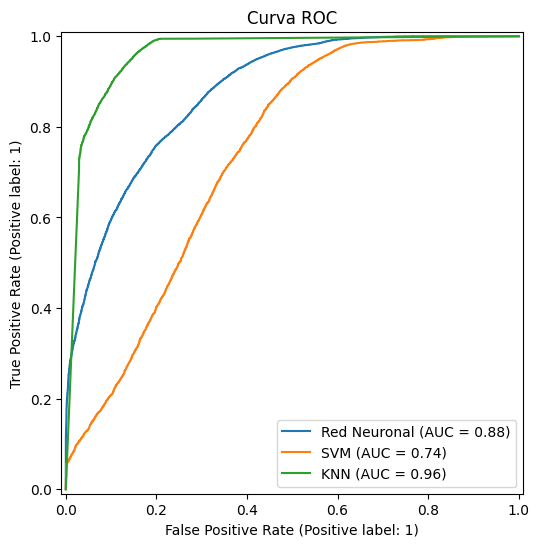

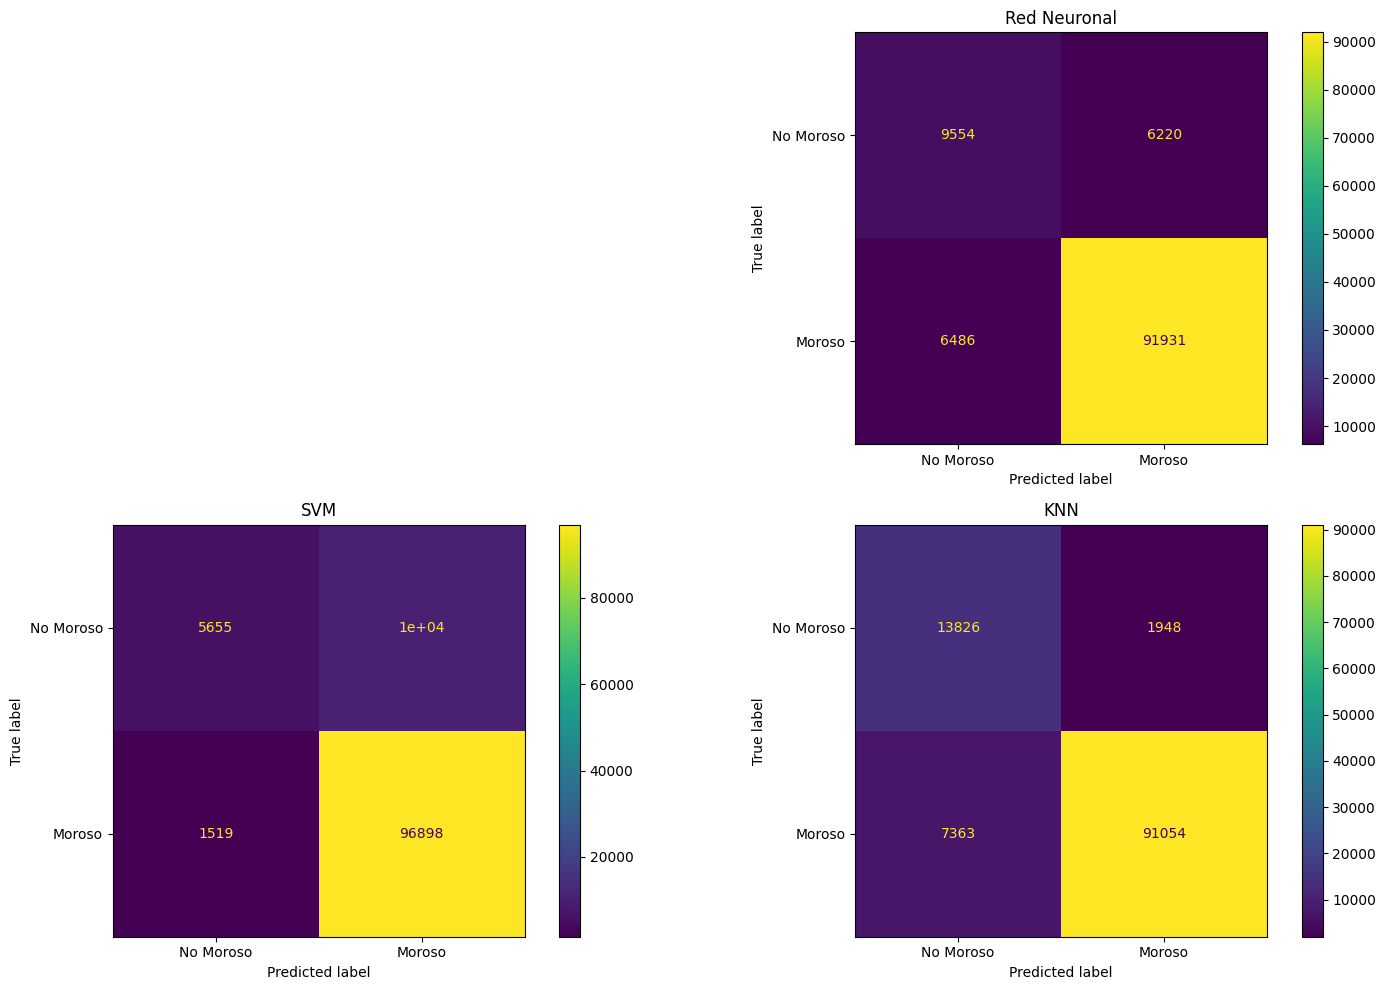

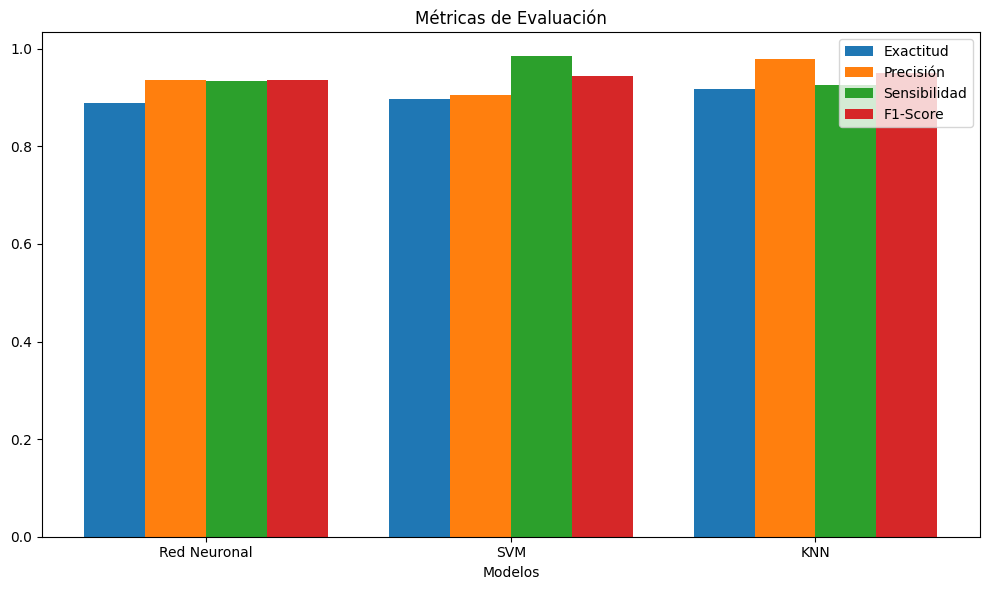

In [7]:
graficar_roc_auc(y_test, y_proba_nn, y_proba_svm, y_proba_knn)
graficar_matriz_confusion(y_test, y_pred_nn, y_pred_svm,  y_pred_knn)
clf_names = [ 'Red Neuronal', 'SVM',  'KNN']
accuracy = [accuracy_score(y_test, y_pred_nn), accuracy_score(y_test, y_pred_svm),  accuracy_score(y_test, y_pred_knn)]
precision = [precision_score(y_test, y_pred_nn), precision_score(y_test, y_pred_svm),  precision_score(y_test, y_pred_knn)]
recall = [recall_score(y_test, y_pred_nn), recall_score(y_test, y_pred_svm), recall_score(y_test, y_pred_knn)]
f1 = [f1_score(y_test, y_pred_nn), f1_score(y_test, y_pred_svm), f1_score(y_test, y_pred_knn)]
graficar_metricas(clf_names, accuracy, precision, recall, f1)

